# Finetuning

# (Q)LoRA finetuning  

### Training <0.1% of the parameters  

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png" alt="drawing" width="600"/>



LoRA injects low rank linear layers (BA) into every linear layer in the architecture. QLoRA is just the addition of quantization to a LoRA model.

Quantization allows to finetune a 7B model on a 4090 by reducing 4x the memory requirements.

Quant reduces model performance, but LoRA is able to mitigate this while also finetuning the model on a downstream task.



## Load the base model

An already finetuned model can be finetuned further, but lets stick to a so-called pretrained model.


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
model_name = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map=0, torch_dtype=torch.bfloat16, attn_implementation='eager'
)


In [2]:
# Inference example

messages = [
    {"role": "user", "content": "¿Cuál es la capital de Australia?"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
).to(model.device)

output_ids = model.generate(input_ids, max_new_tokens=512)
response = tokenizer.batch_decode(output_ids)[0]
print(response)

<bos><start_of_turn>user
¿Cuál es la capital de Australia?<end_of_turn>
<start_of_turn>model
La capital de Australia es Canberra.
<end_of_turn>


# Prepare a dataset
Our example finetuning will perform a simple task using SMILES.
For a given SMILES we will instruct the model to produce the same SMILE but reversed.

I have prepared a dataset with some smiles and their reverses. So from `smile` I want to get `smile[::-1]`.

Although this would be more fitting to a sequence to sequence model, we will encode this as a CausalLM task and finetune on it using next token prediction. The 1B model should be powerful enough to handle it anyhow.


In [3]:
import datasets
import pandas as pd
import numpy as np
dsp = pd.read_csv("small_smiles.csv")
dsp.head()

,smiles,rev_smiles
0,C=CC(=O)N1C[C@@H]2CCOc3c(Cl)c(-c4c(O)cccc4F)c(...,C1]H@C[C2N)43c(cncn4c)F(c)F4cccc)O(c4c-(c)lC(c...
1,COc1ccc2c(c1)OCc1c-2oc2ccccc2c1=O,O=1c2ccccc2co2-c1cCO)1c(c2ccc1cOC
2,COc1ccc2c(c1)NC1=C(C(=O)OC1)C2c1cc(OC)c(OC)c(O...,1c)CO(c)CO(c)CO(cc1c2C)1CO)O=(C(C=1CN)1c(c2ccc...
3,CC[C@@]1(O)C[C@H](OC2CC(N(C)C)C(OC3CC(O)C(OC4C...,CO)O=(C1]H@C[)O=3C2cccc)O(c2c)O=(C)O2c(c3cc(c2...
4,COc1ccc2c(c1)OC(N)=C(C#N)C2c1cc(OC)c(OC)c(OC)c1,1c)CO(c)CO(c)CO(cc1c2C)N#C(C=)N(CO)1c(c2ccc1cOC


### We will create a dataset with labels so that for each `[SMILE]` and `[REV_SMILE]` pair we get:  
`[SMILE]<reversed>[REV_SMILE]<end_of_smile>`  
The tokenizer will prepend each sample with the special token `tokenizer.bos_token` (normally `<s>`) and will place `tokenizer.eos_token` at the end. However, adding our own special separator will help the model.

#### I find that 3K examples are enough for the model to understand the task

In [4]:
subset = 3000
smile_separator = "<reversed>"
smile_end = "<end_of_smile>"
smiles = np.array([s+smile_separator+r+smile_end for s,r in zip(dsp["smiles"][:subset], dsp["rev_smiles"][:subset])])


The tokenizer of a model intended for conversation is not really fit for SMILES, so they will tend to be encoded as a really long series of tokens.

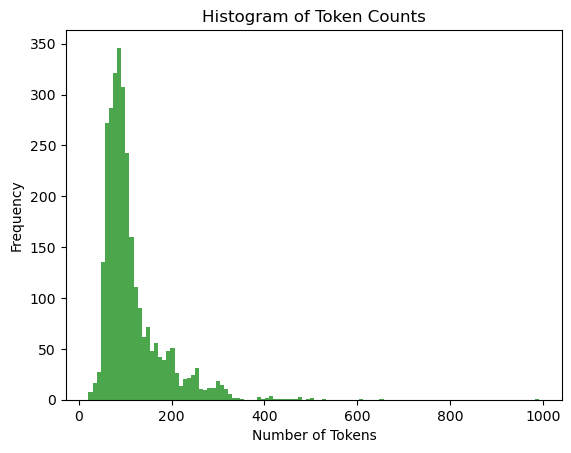

In [5]:
import matplotlib.pyplot as plt
token_counts = np.array([len(tokenizer.encode(text)) for text in smiles])
plt.hist(token_counts, bins='auto', color='green', alpha=0.7)
plt.title('Histogram of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

### Lets filter entries with a token count larger than 512 so we can increase the batch size

In [6]:
filtered_smiles = smiles[token_counts < 512]
print(f"Number of removed entries: {(token_counts>=512).sum()}")
ds = pd.DataFrame.from_dict({"labels": filtered_smiles})
with pd.option_context('display.max_colwidth', 100):
   display(ds.head())
ds = datasets.Dataset.from_pandas(ds)


Number of removed entries: 4


,labels
0,C=CC(=O)N1C[C@@H]2CCOc3c(Cl)c(-c4c(O)cccc4F)c(F)c4ncnc(c34)N2C[C@H]1C<reversed>C1]H@C[C2N)43c(cn...
1,COc1ccc2c(c1)OCc1c-2oc2ccccc2c1=O<reversed>O=1c2ccccc2co2-c1cCO)1c(c2ccc1cOC<end_of_smile>
2,COc1ccc2c(c1)NC1=C(C(=O)OC1)C2c1cc(OC)c(OC)c(OC)c1<reversed>1c)CO(c)CO(c)CO(cc1c2C)1CO)O=(C(C=1C...
3,CC[C@@]1(O)C[C@H](OC2CC(N(C)C)C(OC3CC(O)C(OC4CCC(=O)C(C)O4)C(C)O3)C(C)O2)c2c(cc3c(c2O)C(=O)c2c(O...
4,COc1ccc2c(c1)OC(N)=C(C#N)C2c1cc(OC)c(OC)c(OC)c1<reversed>1c)CO(c)CO(c)CO(cc1c2C)N#C(C=)N(CO)1c(c...


In [7]:
train_test = ds.train_test_split(test_size=0.2)
validation = train_test['test'].train_test_split(test_size=0.5)
split_ds = {
        'train': train_test['train'],
        'validation': validation['train'],
        'test': validation['test']
    }
split_ds


{'train': Dataset({
     features: ['labels'],
     num_rows: 2396
 }),
 'validation': Dataset({
     features: ['labels'],
     num_rows: 300
 }),
 'test': Dataset({
     features: ['labels'],
     num_rows: 300
 })}

--------------------------------------
# Adding a LoRA adapter


In [8]:
import peft # Parameter Efficient Finetuning. Contains utilities for adding adapters to HF models
lora_config = peft.LoraConfig(peft_type=peft.TaskType.CAUSAL_LM,
                              inference_mode=False,
                              r=8, # Rank
                              lora_alpha=32,
                              lora_dropout=0.1)
model = peft.get_peft_model(model, lora_config)
display(model.print_trainable_parameters())

The 8-bit optimizer is not available on your device, only available on CUDA for now.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


trainable params: 745,472 || all params: 1,000,631,424 || trainable%: 0.0745


None

### Inspecting the model reveals that LoRA has been hooked into some of the linear layers

In [9]:
print(model)

PeftModel(
  (base_model): LoraModel(
    (model): Gemma3ForCausalLM(
      (model): Gemma3TextModel(
        (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma3DecoderLayer(
            (self_attn): Gemma3Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1152, out_features=1024, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1152, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
      

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer
# Available optimizers for MPS:
available_optimizers = [
    "adamw_torch"
]

training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    optim=available_optimizers[0],
    num_train_epochs=1,
    logging_steps=100,
    logging_dir="./logs",
    output_dir="./results",
    learning_rate=4e-3,
    max_grad_norm=0.5,
    max_steps=500,
    remove_unused_columns=False
)

# keep tokenizer padding settings
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token

# Pre-tokenize the dataset and create labels for causal LM (labels = input_ids)
def tokenize_fn(examples):
    tokenized = tokenizer(
        examples["labels"],
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    tokenized["labels"] = [ids.copy() for ids in tokenized["input_ids"]]
    return tokenized

tokenized_train = split_ds["train"].map(tokenize_fn, batched=True, remove_columns=["labels"])
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/2396 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2396 [00:00<?, ? examples/s]

In [11]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.
/Users/raul/miniforge3/envs/ollama/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.590300
200,0.385500
300,0.372800
400,0.296200
500,0.283600


TrainOutput(global_step=500, training_loss=0.38568835067749024, metrics={'train_runtime': 678.4203, 'train_samples_per_second': 1.474, 'train_steps_per_second': 0.737, 'total_flos': 2146226798592000.0, 'train_loss': 0.38568835067749024})

# Testing the model

Lets try and see how the model behaves for a task by picking a SMILE and asking for its reverse.

In [12]:
from IPython.display import display, Markdown
i=1 # An arbitrary sample from the test set
smile = [s.split(smile_end)[0] for s in split_ds["test"][i]["labels"].split(smile_separator)] 
tokens = tokenizer(smile[0]+smile_separator, return_tensors="pt").to("mps")
display(Markdown(f"**SMILE:** `{smile[0]}`"))
display(Markdown(f"**Reverse:** `{smile[1]}`"))
display(Markdown(f"**Model input:**`{smile[0]+smile_separator}`"))


**SMILE:** `CC1(C)CC(=O)c2c(C(F)(F)F)nn(-c3ccc(C(N)=O)c(NC4CCC(OC(=O)CN)CC4)c3)c2C1`

**Reverse:** `1C2c)3c)4CC)NC)O=(CO(CCC4CN(c)O=)N(C(ccc3c-(nn)F)F()F(C(c2c)O=(CC)C(1CC`

**Model input:**`CC1(C)CC(=O)c2c(C(F)(F)F)nn(-c3ccc(C(N)=O)c(NC4CCC(OC(=O)CN)CC4)c3)c2C1<reversed>`

## First with the base model

In [13]:
with model.disable_adapter():
   gen_tokens = model.generate(**tokens, max_new_tokens=len(smile[1]))[0]
generated = tokenizer.decode(gen_tokens[tokens["input_ids"].shape[1]:])
display(Markdown("---\n### **Generated**\n------"))
display(Markdown(f"```{generated.split(smile_end)[0]}```"))
display(Markdown("---\n### **Truth**\n------"))
display(Markdown(f"```{smile[1]}```"))

---
### **Generated**
------

```N1C**
Okay, let's break down this SMILE (Structural Model Indicator Language) notation. It describes a molecule with a complex arrangement of atoms.  Here's a detailed explanation:

**1.  CC1(C)CC(=O)c2c(C(F)(F)F)nn(-c```

---
### **Truth**
------

```1C2c)3c)4CC)NC)O=(CO(CCC4CN(c)O=)N(C(ccc3c-(nn)F)F()F(C(c2c)O=(CC)C(1CC```

## Now with the finetuned one

In [14]:
gen_tokens = model.generate(**tokens, max_new_tokens=len(smile[1]))[0]
generated = tokenizer.decode(gen_tokens[tokens["input_ids"].shape[1]:])
display(Markdown("### **Generated**\n------"))
display(Markdown(f"```{generated.split(smile_end)[0]}```"))
display(Markdown("### **Truth**\n------"))
display(Markdown(f"```{smile[1]}```"))


### **Generated**
------

```12c)43c)O=(CN(c)2c)F)F(C=C)F)4OCO)F)F()F)F()F)F(CC(nc2c1NCC(c(c3c(cn)F(c)F(cc3cccc3cC)l```

### **Truth**
------

```1C2c)3c)4CC)NC)O=(CO(CCC4CN(c)O=)N(C(ccc3c-(nn)F)F()F(C(c2c)O=(CC)C(1CC```

# Saving the adapter

In [15]:
model.save_pretrained("adapters/gemma_smiles_rev")

### The information required to take this 15GB model from nonsense to SMILE reverser is just 14MB! 

In [16]:
!ls -lsrht adapters/gemma_smiles_rev

total 6208
  16 -rw-r--r--@ 1 raul  staff   5.1K Aug 14 19:31 README.md
6184 -rw-r--r--@ 1 raul  staff   2.9M Aug 14 19:31 adapter_model.safetensors
   8 -rw-r--r--@ 1 raul  staff   959B Aug 14 19:31 adapter_config.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
